In [1]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

In [2]:
img = cv.imread("mclovin.jpg")

Is a Numpy array with dimensions: (height, width, rgb)

In [3]:
img.shape

(490, 398, 3)

Changes the channels so they are in the same order as the original image

In [4]:
b,g,r = cv.split(img)
img = cv.merge((r,g,b))

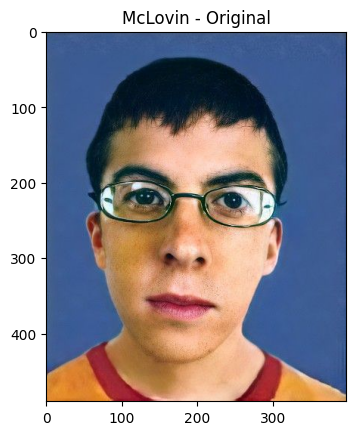

In [5]:
plt.imshow(img)
plt.title("McLovin - Original")
plt.show()

<hr />

#### Enhancing

Histogram Equalization

In [6]:
hist, bins = np.histogram(img.flatten(), 256, [0, 256])

cdf = hist.cumsum()
cdfNorm = cdf * float(hist.max()) / cdf.max()

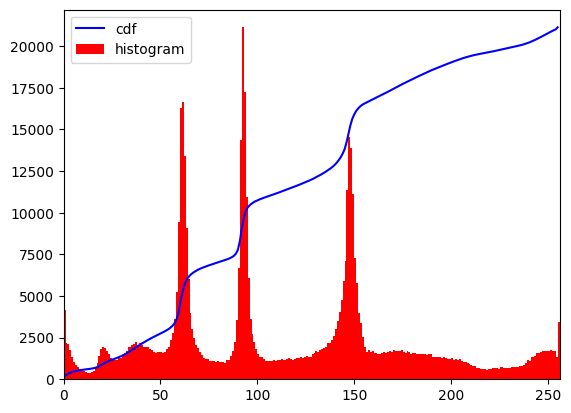

In [7]:
plt.plot(cdfNorm, color = 'b')
plt.hist(img.flatten(),256,[0,256], color = 'r')
plt.xlim([0,256])
plt.legend(('cdf','histogram'), loc = 'upper left')
plt.show()

In [6]:
r,g,b = cv.split(img)
img = cv.merge((g,r,b))

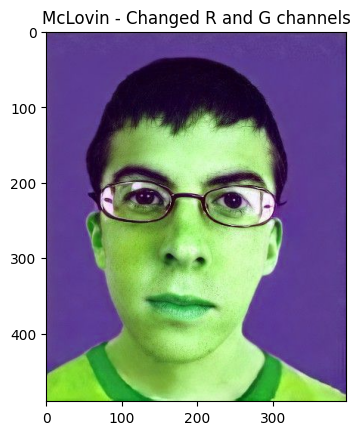

In [7]:
plt.imshow(img)
plt.title("McLovin - Changed R and G channels")
plt.show()

<hr />

#### Edge Detection

In [8]:
img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

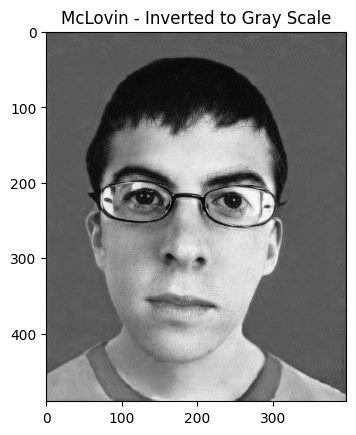

In [9]:
plt.imshow(img, cmap="gray")
plt.title("McLovin - Inverted to Gray Scale")
plt.show()